This code calculates the effect of topographic shading for user-input points on a glacier given by their latitude/longitude based on a DEM of the glacier's surrounding topography. This is output in two .csv files, one containing boolean data shaded yes/no, and the other containing potential clear-sky solar radiation.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import rioxarray as rxr
import rasterio
import xarray as xr
import pandas as pd
import suncalc
from pyproj import Transformer
from numpy import pi, cos, sin, arctan

## INPUTS
Required:
- DEM, aspect and shading .tif files
- Lat/lon coordinates of the point of interest
- Local timezone of the point of interest

Optional:
- Angle step and length to determine the detail in the horizon search
- Plot? This is time-consuming but useful to visualize

In [73]:
# SPECIFY INPUT AND OUTPUT FILEPATHS
fp = '/home/claire/research/'

# INPUT
# dem_fp = fp + '../GulkanaDEM/Gulkana_DEM_20m.tif'
# aspect_fp = fp + '../GulkanaDEM/Gulkana_Aspect_20m.tif'
# slope_fp = fp + '../GulkanaDEM/Gulkana_Slope_20m.tif'
dem_fp = fp + '../GulkanaDEM/2m/Gulkana_USGS_DEM_smooth.tif'
aspect_fp = fp + '../GulkanaDEM/2m/Gulkana_USGS_aspect_from_smooth_DEM.tif'
slope_fp = fp + '../GulkanaDEM/2m/Gulkana_USGS_slope_from_smooth_DEM.tif'

# OUTPUT
out_fp = fp + 'shading/Gulkana.csv'

In [74]:
# INPUTS
lat = 63.260281         # latitude of point of interest
lon = -145.425720       # longitude of point of interest
plot = True             # plot points or not
angle_step = 10         # step to calculate horizon angle in degrees
search_length = 5000           # distance to search from center point (m)
timezone = pd.Timedelta(hours=-9)   # time zone of location

## PREPROCESS

In [75]:
# get UTM coordinates from lat/lon
rds = rxr.open_rasterio(dem_fp) # 32606
transformer = Transformer.from_crs('EPSG:4326', rds.rio.crs, always_xy=True)
xx, yy = transformer.transform(lon, lat)

# get value from grid
value = rds.sel(x=xx, y=yy, method="nearest").values

In [76]:
# OPEN FILES
dem = rxr.open_rasterio(dem_fp).isel(band=0)
aspect = rxr.open_rasterio(aspect_fp).isel(band=0)
# aspect_arr = aspect.GetRasterBand(1).ReadAsArray()
slope = rxr.open_rasterio(slope_fp).isel(band=0)
# slope_arr = slope.GetRasterBand(1).ReadAsArray()
point_elev = dem.sel(x=xx,y=yy,method='nearest').values

## DEFINE FUNCTIONS
Includes functions to get sun position, air pressure, and sun-to-earth radius

In [77]:
# CONSTANTS
I0 = 1368       # solar constant in W m-2
P0 = 101325     # sea-level pressure in Pa
PSI = 0.75       # vertical atmospheric clear-sky transmissivity
r_m = 1         # mean earth-sun radius in AU

def r_sun(time):
    """From DEBAM manual, gets earth-to-sun radius in AU"""
    doy = time.day_of_year
    # From DEBAM manual
    # theta = (2*pi*doy) / 365 * pi/180
    # radius = 1.000110 + 0.34221*cos(theta) + 1.280e-3*sin(theta) + 7.19e-4*cos(2*theta) + 7.7e-5*sin(2*theta)
    radius = 1 - 0.01672*cos(0.9856*(doy-4))
    return radius

def pressure(elev):
    """Adjusts air pressure by elevation"""
    P = np.exp(-0.0001184*elev)*P0
    return P

def zenith(time):
    """Calculates solar zenith angle for time, lat and lon"""
    time_UTC = time - timezone
    altitude_angle = suncalc.get_position(time_UTC,lon,lat)['altitude']
    zenith = pi/2 - altitude_angle if altitude_angle > 0 else np.nan
    return zenith

def declination(time):
    """Calculates solar declination"""
    doy = time.day_of_year
    delta = -23.4*cos(360*(doy+10)/365) * pi/180
    return delta

hour_angle = lambda t: 15*(12-t.day_of_year)

## VISUALIZE

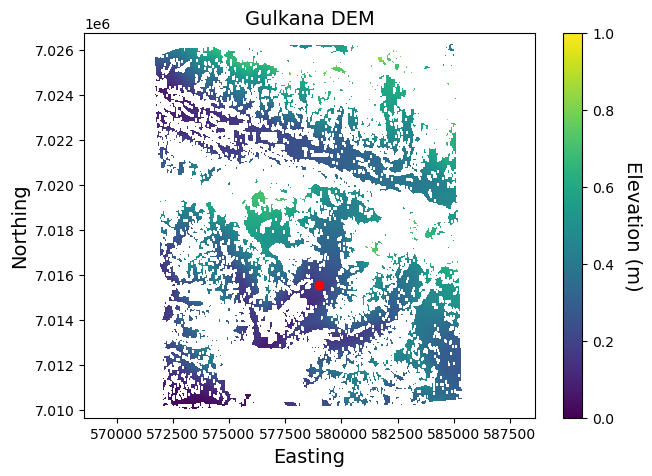

In [78]:
# PLOT DEM
if plot:
    with rasterio.open(dem_fp) as src:
        raster_data = src.read(1,masked=True)
        filtered_data = np.where(raster_data < 0, np.nan, raster_data)
        extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]
        plt.figure(figsize=(16,5))
        plt.subplot(1,2,1)
        plt.imshow(filtered_data,extent=extent,cmap='viridis')
        plt.scatter(xx,yy,color='red')

    # plt.contourf(dem_arr,cmap='viridis',levels=np.linspace(1000,3000,37))
    legend = plt.colorbar()
    legend.ax.set_ylabel('Elevation (m)', rotation=270, fontsize=14, labelpad=20)
    plt.axis('equal') 
    plt.title('Gulkana DEM',fontsize=14)
    plt.xlabel('Easting',fontsize=14)
    plt.ylabel('Northing',fontsize=14)
    plt.show()

Text(0.5, 0.98, 'Sun graph for [63.26,-145.43]')

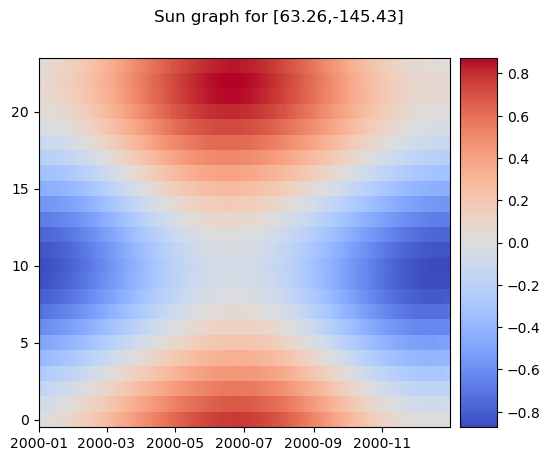

In [88]:
# PLOT SUN GRAPH FOR LAT/LON
all_hours = pd.date_range('2000-01-01 00:00','2000-12-31 23:00',freq='h')
days = pd.date_range('2000-01-01 00:00','2000-12-31 23:00',freq='d')
hours = np.arange(0,24)
Z = np.array(suncalc.get_position(all_hours,lon,lat)['altitude'])
vardata = Z.reshape((len(days),24))

fig,ax = plt.subplots()
pc = ax.pcolormesh(days,hours,vardata.T, cmap='coolwarm')
clb = fig.colorbar(pc,ax=ax,aspect=10,pad=0.02)
fig.suptitle(f'Sun graph for [{lat:.2f},{lon:.2f}]')

### Define function to select gridcells in a given direction from the point

pseudocode
- select a direction
- get array of coordinates that approximately lead that direction from the point of interest
- select those points from the DEM to get an array of elevations
- calculate the slope between the point of interest and each point in the elevation array
- that with the highest slope is the angle of the horizon
- repeat across a bunch of different azimuth angles and integrate or average to get sky view factor
    - in doing so create array of horizon angles for a bunch of different azimuth angles
- loop through time
    - check if solar elevation angle is above the elevation angle for the nearest
    - create array of SHADING (bool) DIRECT SLOPE-CORRECTED IRRADIANCE (float) values
    - export as .csv for a single point in space (x = hours of day, y = days of year)
    - include in exported .csv the sky-view factor (not time-dependent)
- check against something else somehow

TOMORROW
- figure out zenith angle code and maybe don't use suncalc if it's wrong???
- check out whatever Matt sent and if it includes a DEM to test this on, try it out

In [67]:
def select_coordinates(angle,step_size,length):
    """Creates a line of points from the starting cell
    to select grid cells in a given direction (angle in 
    deg 0-360 where 0 is North)"""
    # get starting coordinates
    start_x = xx
    start_y = yy

    # convert angle to radians and make 0 north
    rad = angle * pi/180 + pi/2

    # get change in x and y for each step
    dx = - step_size * cos(rad) # negative so it travels clockwise
    dy = step_size * sin(rad)

    # define end
    n_steps = np.ceil(length / step_size).astype(int)
    end_x = start_x + dx*n_steps
    end_y = start_y + dy*n_steps
    
    # create lines
    xs = np.linspace(start_x,end_x,n_steps)
    ys = np.linspace(start_y,end_y,n_steps)
    if xs.shape > ys.shape:
        ys = np.ones(n_steps) * start_y
    elif ys.shape > xs.shape:
        xs = np.ones(n_steps) * start_x
    
    return xs,ys

In [68]:
def find_horizon(elev,xs,ys,buffer = 30):
    """Finds the horizon along a line of elevation
    values paired to x,y coordinates
    - elev: array of elevations in a single direction
    - xs, ys: coordinates corresponding to elev
    - buffer: defines the minimum number of gridcells
                away the horizon can be found 
                (needed when looking uphill)"""
    # calculate distance from origin and height relative to origin
    distances = np.sqrt((xs-xx)**2+(ys-yy)**2)
    distances[np.where(distances < 1e-3)[0]] = 1e-6
    heights = elev - point_elev
    heights[np.where(heights < 0)[0]] = 0

    # identify maximum horizon elevation angle
    elev_angles = arctan(heights/distances)
    idx = np.argmax(elev_angles[buffer:]) + buffer

    # index out information about the horizon point
    horizon_angle = elev_angles[idx]
    # horizon_distance = distances[idx]
    # horizon_height = heights[idx]
    horizon_x = xs[idx]
    horizon_y = ys[idx]
    return horizon_angle,horizon_x,horizon_y,elev_angles

In [92]:
if plot:
    with rasterio.open(dem_fp) as src:
        raster_data = src.read(1,masked=True)
        filtered_data = np.where(raster_data < 0, np.nan, raster_data)

        extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]
        plt.imshow(filtered_data,extent=extent,cmap='viridis')

    legend = plt.colorbar()
    legend.ax.set_ylabel('Elevation (m)', rotation=270, fontsize=14, labelpad=20)
    plt.axis('equal') 

# filter out missing values
dem = dem.where(dem > 0)

angles = np.arange(0,360,angle_step)
horizons = {}
for ang in angles:
    # set up dict to store
    horizons[ang] = {'horizon_elang':[],'hz_x':[],'hz_y':[],
                     'elev_arr':[],'elang_arr':[],
                     'xs':[],'ys':[]}
    # get line in the direction of choice
    xs, ys = select_coordinates(ang,dem_osgeo.GetGeoTransform()[1],search_length)
    
    # select elevation gridcells along the line
    x_select = xr.DataArray(xs,dims=['location'])
    y_select = xr.DataArray(ys,dims=['location'])
    elev = dem.sel(x=x_select,y=y_select,method='nearest').values

    # filter out nans
    xs = xs[~np.isnan(elev)]
    ys = ys[~np.isnan(elev)]
    elev = elev[~np.isnan(elev)]
    
    # find the horizon
    hz_ang,hz_x,hz_y,all_angles = find_horizon(elev,xs,ys)
    horizons[ang]['horizon_elang'] = hz_ang
    horizons[ang]['hz_x'] = hz_x
    horizons[ang]['hz_y'] = hz_y
    horizons[ang]['elev_arr'] = elev
    horizons[ang]['elang_arr'] = all_angles
    horizons[ang]['xs'] = xs
    horizons[ang]['ys'] = ys

    # visualize elevations 
    if plot:
        min_elev = 1200
        max_elev = 2000
        norm = mpl.colors.Normalize(vmin=min_elev,vmax=max_elev)
        cmap = plt.cm.viridis
        scalar_map = mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
        colors = scalar_map.to_rgba(elev)
        sc = plt.scatter(xs,ys,color=colors,s=5)
        plt.scatter(hz_x,hz_y,color='red',marker='x',s=50)

# calculate sky-view factor
horizon_elev = np.array([horizons[ang]['horizon_elang'] for ang in angles])
angle_step_rad = angle_step * pi/180
sky_view = np.sum(cos(horizon_elev)**2 * angle_step_rad) / (2*pi)

# scatter center point and plot
if plot:
    plt.scatter(xx,yy,color='yellow')
    plt.title(f'Gulkana Centerpoint Sky-view Factor = {sky_view:.3f}')
    plt.ylabel('Northing')
    plt.xlabel('Easting')
    plt.show()

AttributeError: 'DataArray' object has no attribute 'read'

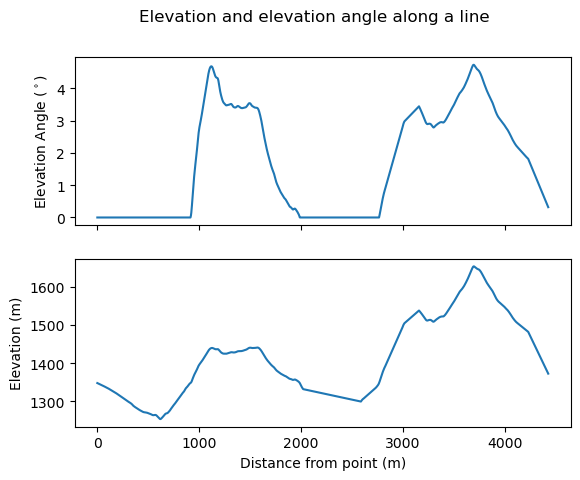

In [70]:
angle_to_vis = 180
xs = horizons[angle_to_vis]['xs']
ys = horizons[angle_to_vis]['ys']
distances = np.sqrt((xs-xx)**2+(ys-yy)**2)
fig_,ax_ = plt.subplots(2,sharex=True)
ax_[0].plot(distances,horizons[angle_to_vis]['elang_arr']*180/pi)
ax_[1].plot(distances,horizons[angle_to_vis]['elev_arr'])
ax_[0].set_ylabel('Elevation Angle ($^\circ$)')
ax_[1].set_ylabel('Elevation (m)')
ax_[1].set_xlabel('Distance from point (m)')
fig_.suptitle('Elevation and elevation angle along a line')
plt.show()

In [1]:
elev = point_elev
all_hours = pd.date_range('2000-01-01 00:00','2000-12-31 23:00',freq='h')
df = pd.DataFrame(data = np.ones((8784,2)),
                  columns=['dirirr','shaded'],index=all_hours)

for time in all_hours:
    P = pressure(elev)
    r = r_sun(time)
    Z = zenith(time)
    d = declination(time)
    h = hour_angle(time)

    I = I0 * (r_m/r)**2 * PSI**(P/P0/np.cos(Z)) * np.cos(Z)

    sun_elev = suncalc.get_position(time,lon,lat)['altitude']
    sun_az = suncalc.get_position(time,lon,lat)['azimuth']               # solar azimuth angle
    asp_north = aspect.sel(x=xx, y=yy, method="nearest").values * pi/180   # slope azimuth angle (aspect)
    asp = asp_north + pi # aspect DEM treats 0 as north, we need as south
    slp = slope.sel(x=xx, y=yy, method="nearest").values * pi/180    # slope angle

    # incident angle calculation
    cosTHETA = cos(slp)*cos(Z) + sin(slp)*sin(Z)*cos(sun_az - asp)
    Islope = I*cosTHETA/cos(Z)
    Islope = max(0,Islope)

    # get nearest angle of horizon calculations to the sun azimuth
    print(angles-sun_az)
    assert 1==0
    idx = np.argmin(np.abs(angles - sun_az))
    # check if the sun elevation angle is below the horizon angle
    if sun_elev < horizon_elev[idx]:
        shaded = 1  # shaded
    else:
        shaded = 0  # not shaded
    
    df.loc[time,'shaded'] = shaded
    df.loc[time,'dirirr'] = Islope
print(df)
# cosOMEGA = (sin(d)*cos(lat) - cos(d)*sin(lat)*cos(h)) / sin(Z) * pi/180
# if time.hour > 12:
#     cosOMEGA = 360 - cosOMEGA
# print(cosOMEGA,cos(omega),omega)

NameError: name 'point_elev' is not defined

In [91]:
dem.rio.resolution()[0]

2.0

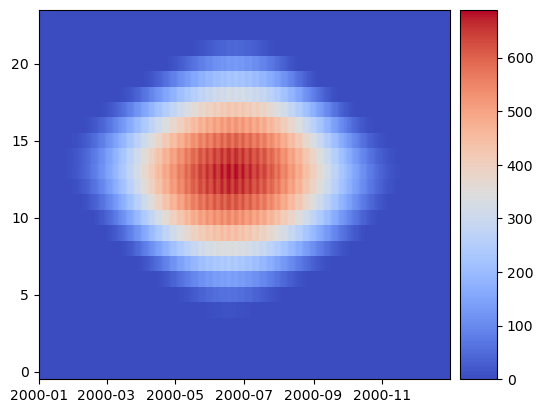

In [89]:
days = pd.date_range('2000-01-01 00:00','2000-12-31 23:00',freq='d')
hours = np.arange(0,24)
vardata = df['dirirr'].to_numpy().reshape((len(days),24))

fig,ax = plt.subplots()
pc = ax.pcolormesh(days,hours,vardata.T, cmap='coolwarm')
# ticks = np.linspace(np.ceil(np.min(vardata)),np.floor(np.max(vardata)),3)
# if ticks[1]%1 > 0:
#     ticks =  np.linspace(np.ceil(np.min(vardata)),np.floor(np.max(vardata))+1,3)
clb = fig.colorbar(pc,ax=ax,aspect=10,pad=0.02)

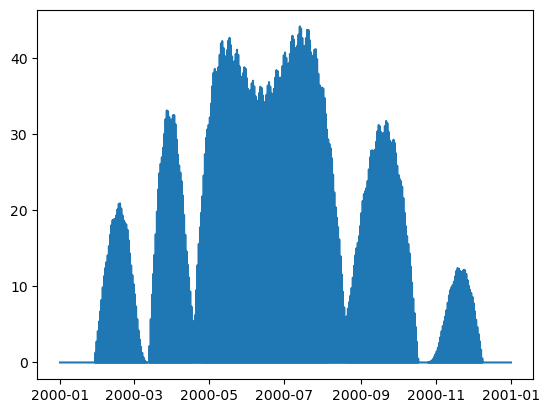

In [246]:
plt.plot(df.index,df['dirirr'])

In [64]:
altitude_angle = suncalc.get_position(time,lon,lat)['altitude']
zenith = 180/np.pi * (np.pi/2 - altitude_angle) if altitude_angle > 0 else 89